In [ ]:
# Naive Bayes

The purpose of this notebook is to read in the [UCI mushroom dataset](https://archive.ics.uci.edu/ml/datasets/Mushroom) and apply Naive Bayes Classification.

* Learn about Naive Bayes and include the basic principles in Markdown
* Import dataset both locally and directly from the web
* Make a few simple plots looking at the dataset


In [1]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
from urllib.request import urlretrieve

In [2]:
# Read in data. it's comma-separated with no column names.
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
# Save file locally
# urlretrieve(url, "agaricus-lepiota.data")
df = pd.read_csv('agaricus-lepiota.data', sep=',', header=None)

#manually add column names from documentation (1st col is class: e=edible,p=poisonous; rest are attributes)
df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
             'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
             'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
             'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']

In [3]:
print(df.head())

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color   ...   stalk-surf-below-ring  \
0            c         n          k   ...                       s   
1            c         b          k   ...                       s   
2            c         b          n   ...                       s   
3            c         n          n   ...                       s   
4            w         b          k   ...                       s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

e    4208
p    3916
Name: class, dtype: int64


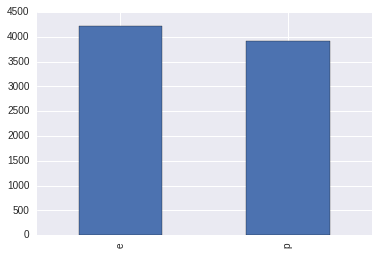

In [4]:
#show plots in notebook
%matplotlib inline

#bar chart of classes using pandas plotting
print(df['class'].value_counts())
df['class'].value_counts().plot(kind='bar')

This plot shows the number of edible mushrroms in the dataset against the number of poisonous mushrooms. There are slightly more edible mushrooms than poisonous ones but they are fairly evenly split.  Now I will visually inspect the features for any predictive/non-predicitive features. 

In [ ]:
print(df['spore-color'].value_counts())

#seaborn factorplot to show edible/poisonous breakdown by different factors
#df_forplot = df.loc[:,('class','cap-shape','gill-color')]
#g = sns.factorplot("class", col="cap-shape", data=df_forplot,
 #                   kind="count", size=2.5, aspect=.8, col_wrap=6)

sns.factorplot("class", col = "spore-color", data = df, kind = "count", col_wrap = 5)    

Spore colour seems to be a strong indicator of poisonous/edible.
Perhaps it might be worth looking at the PCA decomposition?

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)

ValueError: could not convert string to float: 'l'